## 药物干预配受体筛选

In [1]:
library(dplyr)
library(tidyr)
library(readr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# 读取数据
control1 <- read_csv("/home/zhangyinan/TXL_new/14_stlearn/Control3_Model1_Treatment2/result/control3/LR_detail_p_0.05.csv") %>% rename(pair = 1) %>% mutate(group = "control")
control2 <- read_csv("/home/zhangyinan/TXL_new/14_stlearn/Control5_Model2_Treatment3/result/control5/LR_detail_p_0.05.csv") %>% rename(pair = 1) %>% mutate(group = "control")
model1 <- read_csv("/home/zhangyinan/TXL_new/14_stlearn/Control3_Model1_Treatment2/result/model1/LR_detail_p_0.05.csv") %>% rename(pair = 1) %>% mutate(group = "model")
model2 <- read_csv("/home/zhangyinan/TXL_new/14_stlearn/Control5_Model2_Treatment3/result/model2/LR_detail_p_0.05.csv") %>% rename(pair = 1) %>% mutate(group = "model")
treat1 <- read_csv("/home/zhangyinan/TXL_new/14_stlearn/Control3_Model1_Treatment2/result/treatment2/LR_detail_p_0.05.csv") %>% rename(pair = 1) %>% mutate(group = "treatment")
treat2 <- read_csv("/home/zhangyinan/TXL_new/14_stlearn/Control5_Model2_Treatment3/result/treatment3/LR_detail_p_0.05.csv") %>% rename(pair = 1) %>% mutate(group = "treatment")

New names:
• `` -> `...1`
Rows: 745 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (3): n_spots, n_spots_sig, n_spots_sig_pval

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 829 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (3): n_spots, n_spots_sig, n_spots_sig_pval

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 955 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (3): n_spots, n_spots_sig, n_spots_sig_pval

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ 

In [3]:
# 合并所有样本
all_data <- bind_rows(control1, control2, model1, model2, treat1, treat2)
head(all_data)

pair,n_spots,n_spots_sig,n_spots_sig_pval,group
<chr>,<dbl>,<dbl>,<dbl>,<chr>
Vip_Adcyap1r1,373,30,91,control
Nectin3_Nectin3,117,28,85,control
Robo2_Robo2,353,19,76,control
Cadm1_Cadm1,449,18,85,control
Npy_Npy1r,400,18,76,control
Sst_Sstr1,335,17,61,control


In [4]:
# 计算每个pair在每组的均值
summary_data <- all_data %>%
  group_by(pair, group) %>%
  summarise(mean_sig = mean(n_spots_sig, na.rm = TRUE), .groups = "drop")
head(summary_data)

pair,group,mean_sig
<chr>,<chr>,<dbl>
A2m_Lrp1,control,2.5
A2m_Lrp1,model,7.0
A2m_Lrp1,treatment,6.0
Ace_Bdkrb2,model,4.0
Adam12_Itga9,model,7.0
Adam12_Itga9,treatment,2.0


In [5]:
# 将数据转为宽格式，便于计算RI
summary_wide <- summary_data %>%
  pivot_wider(names_from = group, values_from = mean_sig)
head(summary_wide)

pair,control,model,treatment
<chr>,<dbl>,<dbl>,<dbl>
A2m_Lrp1,2.5,7.0,6.0
Ace_Bdkrb2,NA,4.0,NA
Adam12_Itga9,NA,7.0,2.0
Adam12_Itgb1,3.0,6.5,2.5
Adam12_Sdc4,1.5,13.5,2.5
Adam15_Itga5,2.5,8.5,4.0


In [6]:
# 设置阈值
threshold_model = 9     # Model 与 Control 的最小差异，用于筛选损伤明显的配受体
threshold_recovery = 0.5  # Control 与 Treatment 的最大允许差异，表示接近正常

In [7]:
mean_data = summary_wide

In [8]:
mean_data_filtered <- mean_data %>%
  # 筛选 model vs control 差异显著的配受体
  filter(abs(model - control) >= threshold_model) %>%
  # 筛选 treatment 已接近 control 的配受体
  filter(abs(treatment - control) <= threshold_recovery) %>%
  # 判断修复方向
  mutate(
    direction_correct = (model - control) * (treatment - model) < 0,
    RI_raw = abs(treatment - control) / abs(model - control),
    dRI = ifelse(direction_correct, RI_raw, -RI_raw)
  ) %>%
  arrange(desc(dRI))


In [9]:
head(mean_data_filtered)

pair,control,model,treatment,direction_correct,RI_raw,dRI
<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>
Hbegf_Cd9,1.0,10.0,1.5,TRUE,0.05555556,0.05555556
Ptprz1_Ncam1,1.5,10.5,2.0,TRUE,0.05555556,0.05555556
Apoe_Scarb1,0.0,9.5,0.5,TRUE,0.05263158,0.05263158
Apoe_Sorl1,0.0,10.0,0.5,TRUE,0.05000000,0.05000000
Sema4d_Plxnb2,2.0,12.5,2.5,TRUE,0.04761905,0.04761905
Serpinf1_Plxdc2,2.5,13.0,2.0,TRUE,0.04761905,0.04761905


In [10]:
dim(mean_data_filtered)

[1] 10  7

In [11]:
write_csv(mean_data_filtered, "/home/zhangyinan/TXL_new/14_stlearn/other/recovery_index_results_top10.csv")

## 绘制热图

In [12]:
library(ggplot2)
library(tidyr)
library(dplyr)
library(ggnewscale)

In [13]:
mean_data_filtered = read.csv("/home/zhangyinan/TXL_new/14_stlearn/other/recovery_index_results_top32.csv")
head(mean_data_filtered)

,pair,control,model,treatment,direction_correct,RI_raw,dRI
,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>
1,Apoe_Lrp1,0.0,6.0,0.5,TRUE,0.08333333,0.08333333
2,Icam1_Itgam,1.5,7.5,2.0,TRUE,0.08333333,0.08333333
3,Il34_Ptprz1,3.5,9.5,3.0,TRUE,0.08333333,0.08333333
4,Vegfa_Gpc1,2.0,8.0,2.5,TRUE,0.08333333,0.08333333
5,Apoe_Ldlr,1.0,7.5,0.5,TRUE,0.07692308,0.07692308
6,Fn1_Mag,0.0,6.5,0.5,TRUE,0.07692308,0.07692308


In [14]:
# 转换成长格式
df_long <- mean_data_filtered %>%
  select(pair, control, model, treatment, dRI) %>%
  pivot_longer(cols = -pair, names_to = "condition", values_to = "value")

In [15]:
# 分组变量：前3列为表达量，最后1列为dRI
df_long <- df_long %>%
  mutate(type = ifelse(condition == "dRI", "recovery", "expression"))

# 设置绘图顺序
df_long$condition <- factor(df_long$condition, 
                            levels = c("control", "model", "treatment", "dRI"))

In [16]:
# 绘图
p <- ggplot() +
  # --- 表达量部分 ---
  geom_tile(
    data = df_long %>% filter(type == "expression"),
    aes(x = condition, y = pair, fill = value),
    color = "white", size = 0.5
  ) +
  scale_fill_gradientn(colors = c("#2166AB", "white", "#B01326"), 
                       name = "Expression") +
  new_scale_fill() +
  # --- dRI 部分 ---
  geom_tile(
    data = df_long %>% filter(type == "recovery"),
    aes(x = condition, y = pair, fill = value),
    color = "white", size = 0.5
  ) +
  scale_fill_gradientn(colors = c("#2E8B57", "white"),
                       name = "dRI") +
  coord_fixed(ratio = 1) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.title = element_blank(),
    panel.grid = element_blank(),
    legend.position = "right"
  )

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


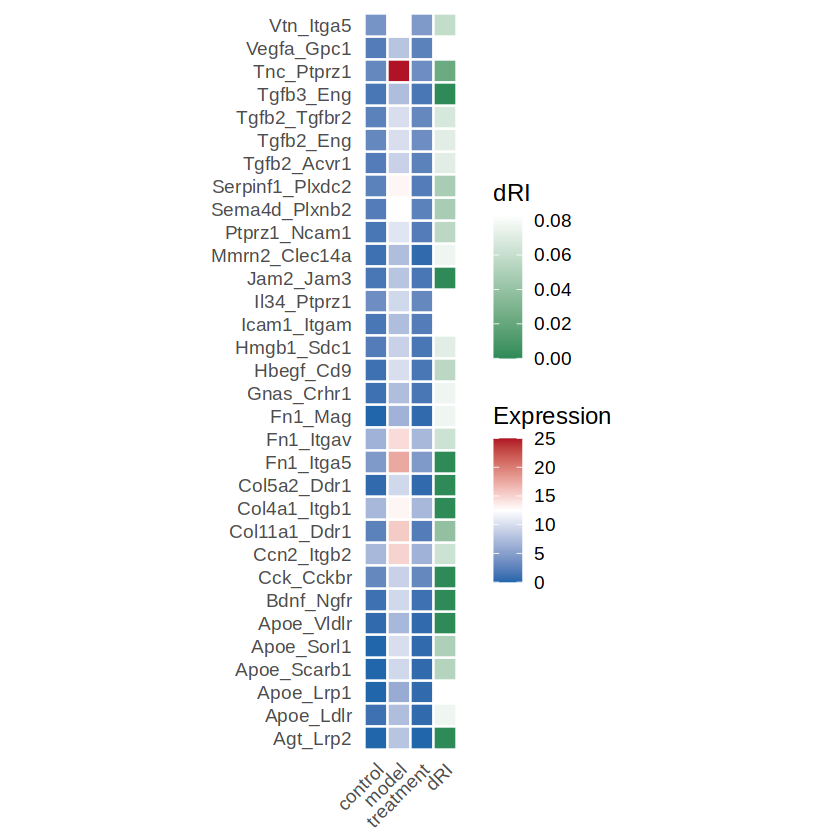

In [17]:
p

In [18]:
pdf("/home/zhangyinan/TXL_new/14_stlearn/other/ligand_receptor_heatmap_dRI.pdf", width = 8, height = 8)  
print(p)
dev.off()

png 
  2